# Student Habits Performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1: Load Dataset

In [2]:
df = pd.read_csv("student_habits_performance.csv")
print("Shape:", df.shape)
df.head()

Shape: (1000, 16)


,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


# 3: Data Preprocessing & Cleaning

In [3]:
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     1000 non-null   object 
 1   age                            1000 non-null   int64  
 2   gender                         1000 non-null   object 
 3   study_hours_per_day            1000 non-null   float64
 4   social_media_hours             1000 non-null   float64
 5   netflix_hours                  1000 non-null   float64
 6   part_time_job                  1000 non-null   object 
 7   attendance_percentage          1000 non-null   float64
 8   sleep_hours                    1000 non-null   float64
 9   diet_quality                   1000 non-null   object 
 10  exercise_frequency             1000 non-null   int64  
 11  parental_education_level       909 non-null    object 
 12  internet_quality               1000 non-null   ob

In [4]:
df=df.dropna()

In [5]:
df.isna().sum()

student_id                       0
age                              0
gender                           0
study_hours_per_day              0
social_media_hours               0
netflix_hours                    0
part_time_job                    0
attendance_percentage            0
sleep_hours                      0
diet_quality                     0
exercise_frequency               0
parental_education_level         0
internet_quality                 0
mental_health_rating             0
extracurricular_participation    0
exam_score                       0
dtype: int64

# 4: Exploratory Data Analysis (EDA)

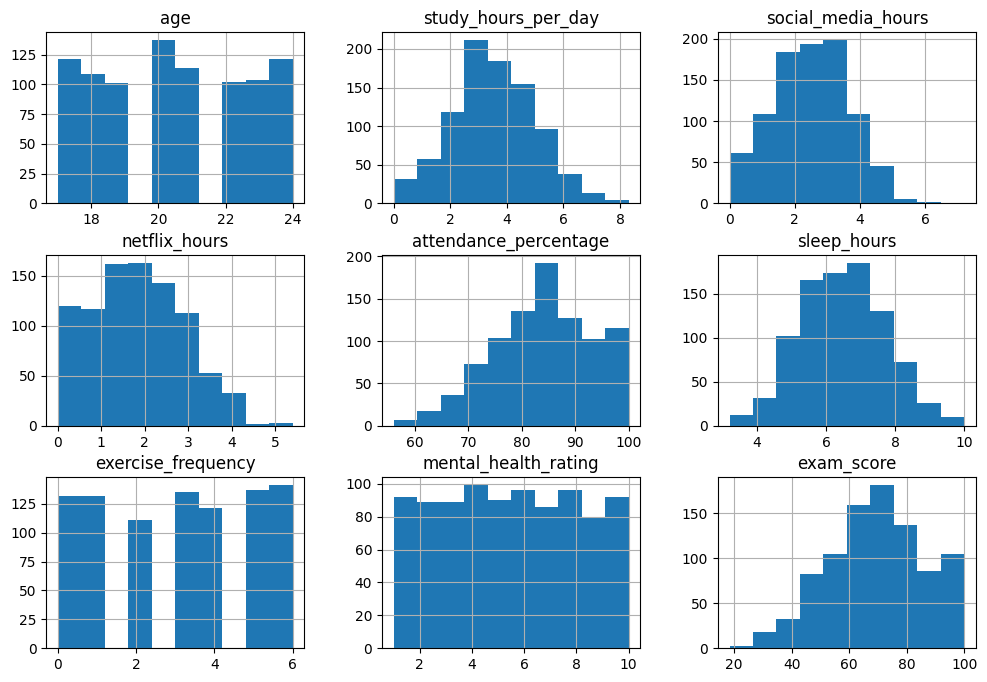

In [6]:
df.hist(figsize=(12, 8))
plt.show()

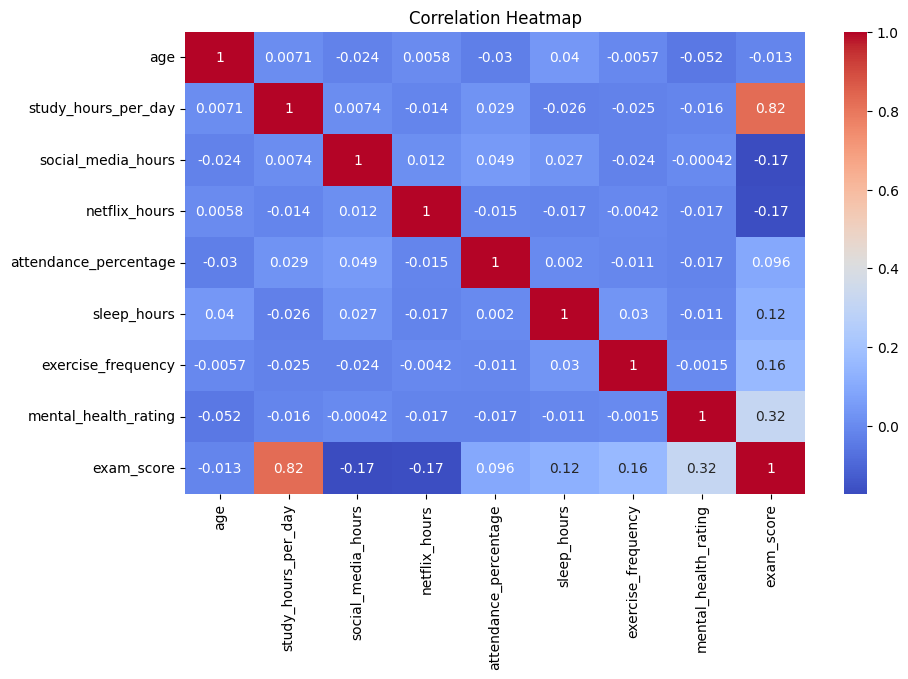

In [7]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# 5: Feature Engineering & Target Variable

In [8]:
target = "exam_score"
X = df.drop(columns=[target])
y = df[target]

# Separate numeric and categorical
num_features = X.select_dtypes(include=[np.number]).columns
cat_features = X.select_dtypes(exclude=[np.number]).columns

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

In [9]:
# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (727, 15) Test shape: (182, 15)


In [10]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=200, random_state=42),
}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="r2")
    results.append({"Model": name, "CV Mean R2": scores.mean(), "CV Std": scores.std()})
    print(f"{name}: R2 = {scores.mean():.4f} ± {scores.std():.4f}")

results_df = pd.DataFrame(results)
results_df


LinearRegression: R2 = 0.8950 ± 0.0103
RandomForestRegressor: R2 = 0.8467 ± 0.0166


,Model,CV Mean R2,CV Std
0,LinearRegression,0.894988,0.010347
1,RandomForestRegressor,0.846750,0.016574


In [11]:
best_model_name = results_df.sort_values("CV Mean R2", ascending=False).iloc[0]["Model"]
print("Best model selected:", best_model_name)

best_model = models[best_model_name]
best_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", best_model)])
best_pipe.fit(X_train, y_train)

# Predictions
y_pred = best_pipe.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
print("Test RMSE:", rmse)
print("Test R2:", r2)


Best model selected: LinearRegression
Test RMSE: 5.47687954085755
Test R2: 0.889489469319042


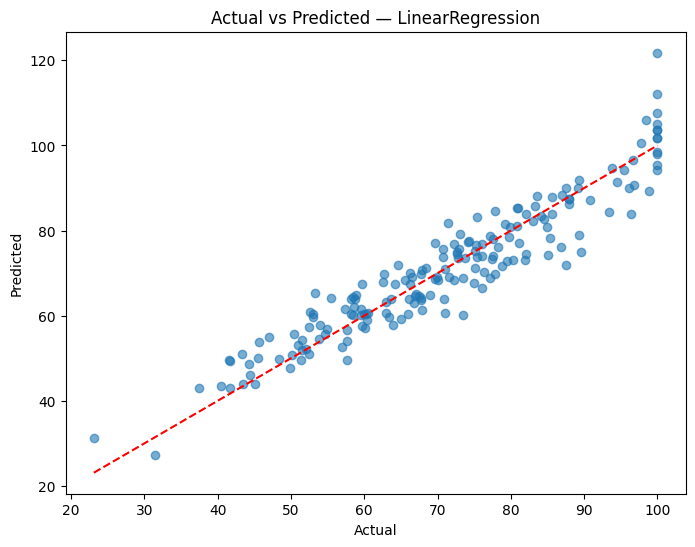

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Actual vs Predicted — {best_model_name}")
plt.show()


C:\Users\tiwar\AppData\Local\Temp\ipykernel_13808\1920573412.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="gender", data=df, palette="Set2")


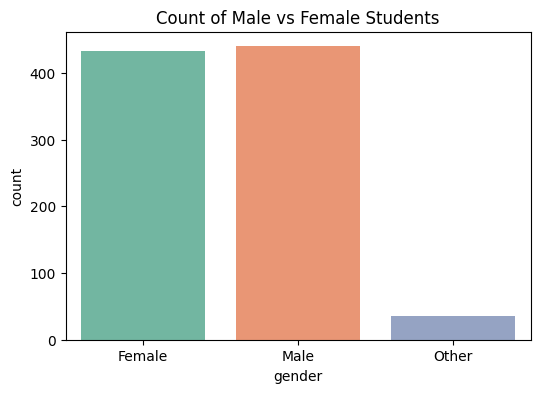

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x="gender", data=df, palette="Set2")
plt.title("Count of Male vs Female Students")
plt.show()

C:\Users\tiwar\AppData\Local\Temp\ipykernel_13808\1125439126.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="gender", y="exam_score", data=df, palette="Set2", ci=None)
C:\Users\tiwar\AppData\Local\Temp\ipykernel_13808\1125439126.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="gender", y="exam_score", data=df, palette="Set2", ci=None)


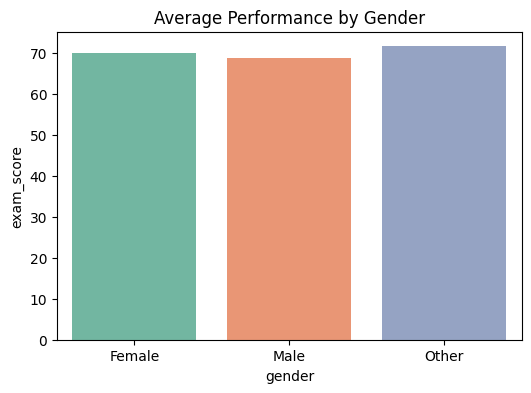

In [14]:
plt.figure(figsize=(6,4))
sns.barplot(x="gender", y="exam_score", data=df, palette="Set2", ci=None)
plt.title("Average Performance by Gender")
plt.show()


C:\Users\tiwar\AppData\Local\Temp\ipykernel_13808\2678340715.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="gender", y="study_hours_per_day", data=df, palette="Set2")


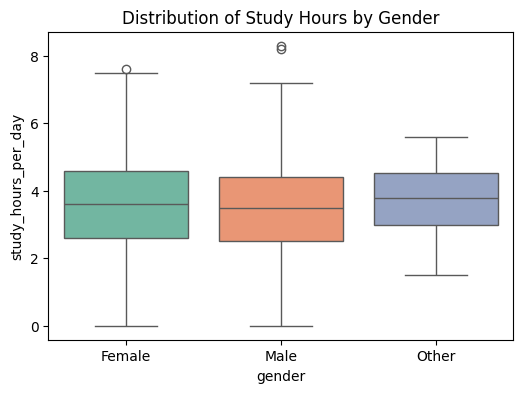

In [15]:
plt.figure(figsize=(6,4))
sns.boxplot(x="gender", y="study_hours_per_day", data=df, palette="Set2")
plt.title("Distribution of Study Hours by Gender")
plt.show()


In [17]:
df.to_csv("student_habits_cleaned.csv", index=False)

df.to_excel("student_habits_cleaned.xlsx", index=False)